In [1]:
from itertools import combinations

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from scipy.stats import spearmanr, pearsonr

from constants import (
    exclude_models,
    exclude_models_w_mae,
    cat_name_mapping,
    model_config_file,
    fontsizes,
    fontsizes_cols,
    model_cat_mapping,
    BASE_PATH_RESULTS,
    BASE_PATH_PROJECT,
    ds_list_sim_file
)
from helper import load_model_configs_and_allowed_models, save_or_show, pp_storing_path, load_all_datasetnames_n_info, load_similarity_matrices

In [2]:
# Define the path to the similarity matrices
base_path_similarity_matrices = BASE_PATH_PROJECT / 'model_similarities_in1k_places'

# Define similarity metrics to be used
sim_metrics = [
    'cka_kernel_linear_unbiased',
]

# Load used dataset names
ds_list, ds_info = load_all_datasetnames_n_info('../scripts/configs/webdatasets_wo_in1k_breeds.txt', verbose=False)

ds_list = ds_list[0:8]
ds_info = ds_info[0:8]

# Define model filtering suffix
suffix = ''  # '_wo_mae'

# Version
version = 'arxiv'  #'arxiv'

# Define storing information
SAVE = False
storing_path = pp_storing_path(BASE_PATH_RESULTS / 'plots' / 'final' / version / 'in1k_vs_places', SAVE)

In [3]:
# Load model configurations and allowed models
model_configs, allowed_models = load_model_configs_and_allowed_models(
    path='../scripts/configs/models_config_places_vs_in1k.json',
    exclude_models=[],
    exclude_alignment=True,
)

Nr. models original=8


In [4]:
# Load similarity matrices
sim_mats = load_similarity_matrices(
    path=base_path_similarity_matrices,
    ds_list=ds_list,
    sim_metrics=sim_metrics,
    allowed_models=allowed_models,
)

In [5]:
sim_mats = sim_mats['cka_kernel_linear_unbiased']

#### Create heatmaps

In [6]:
order = [
    'alexnet_places365',
    'densenet161_places365',
    'resnet18_places365',
    'resnet50_places365',
    'alexnet',
    'densenet161',
    'resnet18',
    'resnet50',
 ]

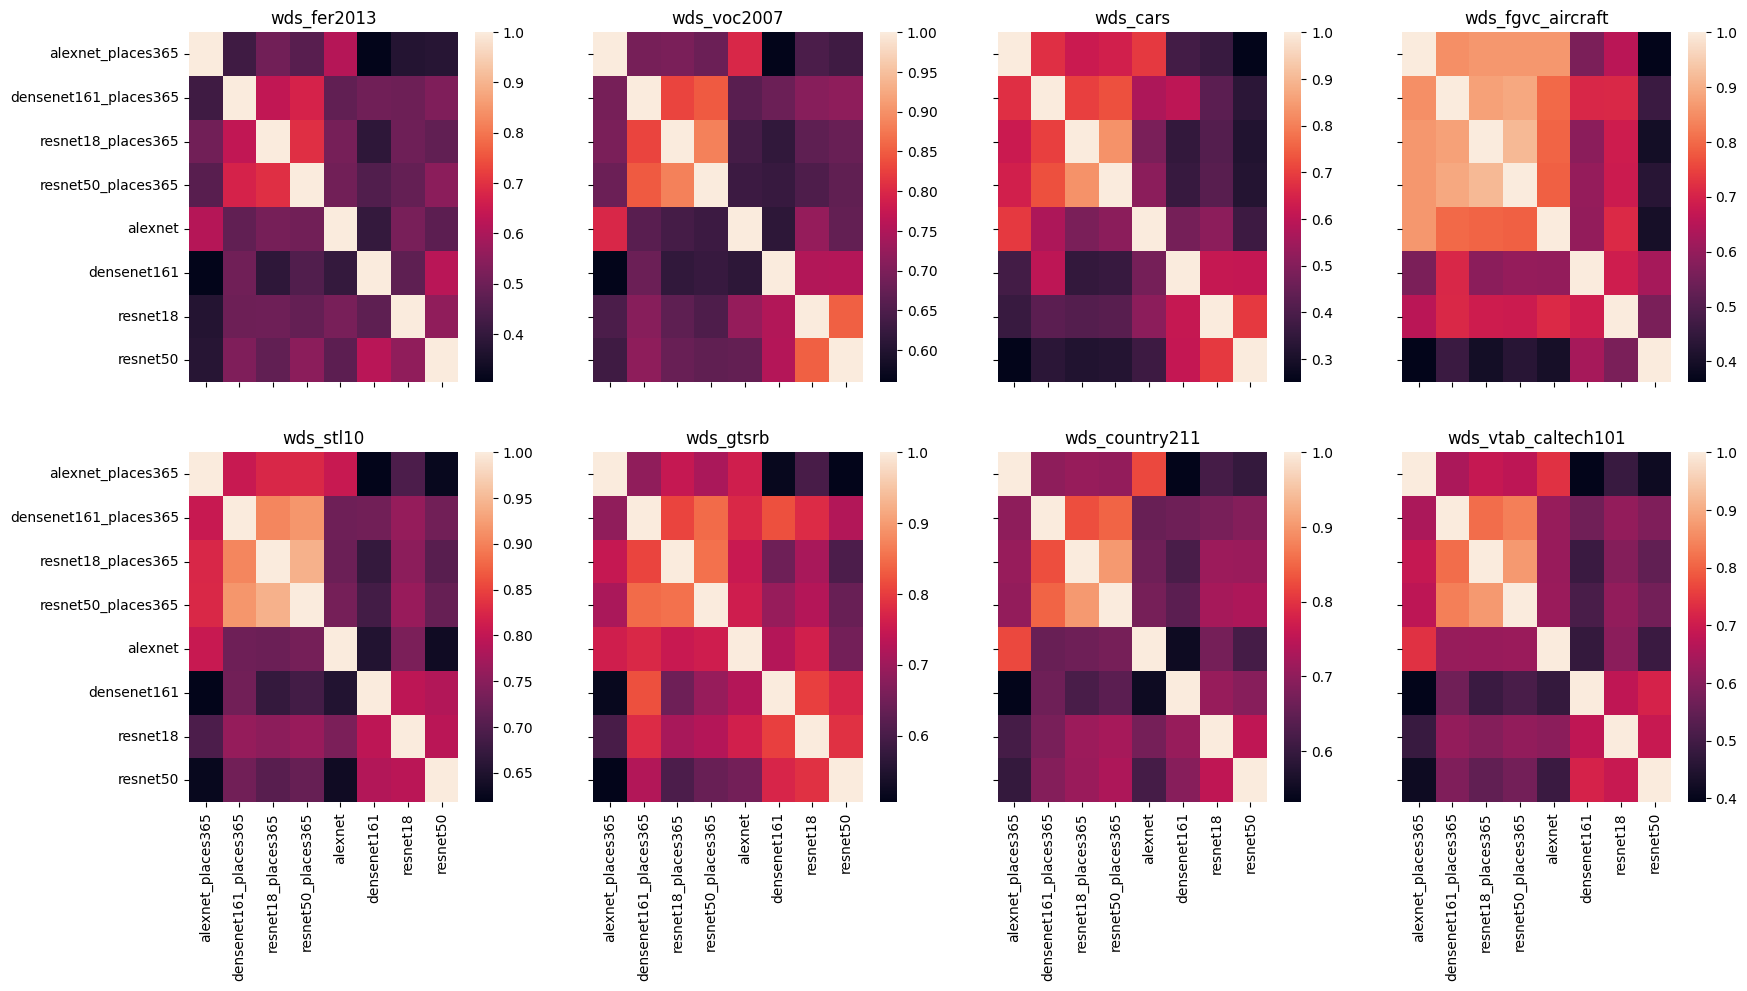

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(4*5, 2*5), sharex=True, sharey=True)
axes = axes.flatten()
for i,(k, v) in enumerate(sim_mats.items()):
    sns.heatmap(v.loc[order, order], ax=axes[i])
    axes[i].set_title(k)
    

In [8]:
import numpy as np

def get_pair_cat(row):
    if 'places' in row['model_M1']:
        M1_cat = 'Places365'
    else:
        M1_cat = 'IN1K'

    if 'places' in row['model_M2']:
        M2_cat = 'Places365'
    else:
        M2_cat = 'IN1K'
    return tuple(sorted((M1_cat, M2_cat)))
        

def pp_sim_mat(df):
    idx = np.triu_indices_from(df.values, k=1)
    flat_df = pd.DataFrame(dict(
        sim_values = df.values[idx],
        model_M1 = df.index.values[idx[0]],
        model_M2 = df.index.values[idx[1]]
    ))

    flat_df['model_pair'] = flat_df[['model_M1', 'model_M2']].apply(tuple, axis=1)
    flat_df['train_ds_pair'] = flat_df[['model_M1', 'model_M2']].apply(get_pair_cat, axis=1)
    

    return flat_df

In [9]:
pp_sim_mats = { k:pp_sim_mat(v) for k,v in sim_mats.items()}

In [10]:
pp_sim_mats.keys()

dict_keys(['wds_fer2013', 'wds_voc2007', 'wds_cars', 'wds_fgvc_aircraft', 'wds_stl10', 'wds_gtsrb', 'wds_country211', 'wds_vtab_caltech101'])

In [11]:
import itertools
ds_pairs = list(itertools.combinations(pp_sim_mats.keys(), 2))

In [12]:
len(ds_pairs)

28

In [13]:
corr_method = 'pearsonr'

def correlation(x, y):
    corr = None
    if corr_method == 'spearmanr':
        corr, _ = spearmanr(x, y)
    elif corr_method == 'kendalltau':
        corr, _ = kendalltau(x, y)
    elif corr_method == 'pearsonr':
        corr, _ = pearsonr(x, y)
    return corr

In [14]:
def compute_corrs_ds_pair(p1, p2):
    corrs = {}
    for pair_cat, pair_data in p1.groupby('train_ds_pair'):
        sim_1 = pair_data['sim_values']
        sim_2 = p2.loc[pair_data.index]['sim_values']
        corrs[pair_cat] = correlation(sim_1, sim_2)
    corrs['all'] = correlation(p1['sim_values'], p2['sim_values'])
    return corrs

In [15]:
all_corrs = []
for ds1, ds2 in ds_pairs:
    p1 = pp_sim_mats[ds1]
    p2 = pp_sim_mats[ds2]
    p1_p2_corrs = compute_corrs_ds_pair(p1, p2)
    p1_p2_corrs['ds1'] = ds1
    p1_p2_corrs['ds2'] = ds2
    all_corrs.append(p1_p2_corrs)

In [17]:
all_corrs = pd.DataFrame(all_corrs)

In [26]:
all_corrs.columns = ['IN1K, IN1K', 'IN1K, Places365', 'Places365, Places365', 'All combs', 'ds1', 'ds2']

([0, 1, 2, 3],
 [Text(0, 0, 'IN1K, IN1K'),
  Text(1, 0, 'IN1K, Places365'),
  Text(2, 0, 'Places365, Places365'),
  Text(3, 0, 'All combs')])

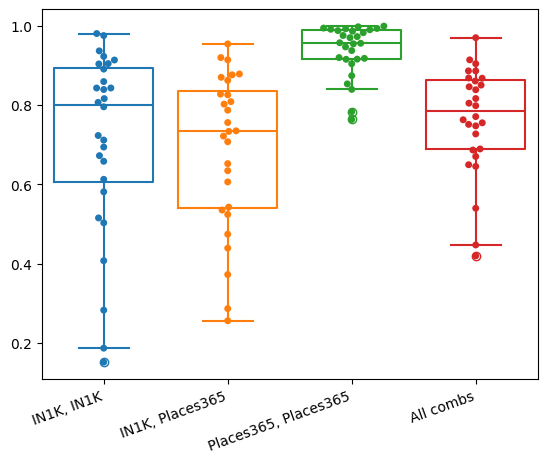

In [31]:
sns.boxplot(all_corrs, fill=False)
sns.swarmplot(all_corrs, edgecolor='black')
plt.xticks(rotation=20, ha='right')

<Axes: xlabel='sim_values', ylabel='sim_values'>

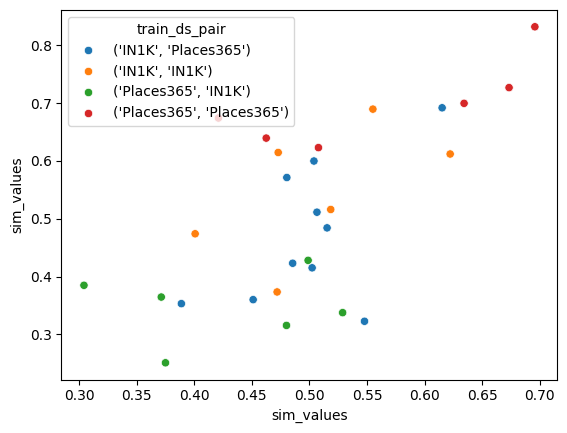

In [102]:
sns.scatterplot(
    x=pp_sim_mats['wds_fer2013']['sim_values'], 
    y=pp_sim_mats['wds_cars']['sim_values'],
    hue=pp_sim_mats['wds_fer2013']['train_ds_pair']
)